## Intrusion Detection Packet Classification by type of attacks
### Capston B

In [4]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf 
import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize

Preprocessing -Transformation and Scaling 

In [5]:
train = pd.read_csv('G:/SMU Data Science/SMU Courses/DS 6120 Capstone A/UNSW-NB15 Data Set/UNSW_NB15_training-set.csv')
test = pd.read_csv('G:/SMU Data Science/SMU Courses/DS 6120 Capstone A/UNSW-NB15 Data Set/UNSW_NB15_testing-set.csv')
list_events = pd.read_csv("G:/SMU Data Science/SMU Courses/DS 6120 Capstone A/UNSW-NB15 Data Set/UNSW-NB15_LIST_EVENTS.csv")
features = pd.read_csv("G:/SMU Data Science/SMU Courses/DS 6120 Capstone A/UNSW-NB15 Data Set/NUSW-NB15_features.csv",encoding='latin1')
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

Function to encode string features

In [6]:
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode())
print("mode", len(np.where(vector.values==6)[0])/len(vector),"%")
print("looks like 6 is 'normal', but its not that common")

attack cat: {'Fuzzers', 'Worms', 'Shellcode', 'Reconnaissance', 'Normal', 'Analysis', 'Generic', 'Exploits', 'DoS', 'Backdoor'}

Describing attack_type: 
min 0
max 9
mode 0    6
dtype: int32
mode 0.3609225646458884 %
looks like 6 is 'normal', but its not that common


In [7]:
le1.inverse_transform([0,1,2,3,4,5,6,7,8,9,])

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

Dropping thr features of Low Standard deviation and Low corr

In [10]:
lowSTD = list(combined_data.std().to_frame().nsmallest(6,columns=0).index)
lowCORR = list(combined_data.corr().abs().sort_values('attack_cat')['attack_cat'].nsmallest(3).index) # .where(lambda x: x < 0.005).dropna()
drop = set( lowCORR + lowSTD)
#drop = {'ackdat', 'ct_ftp_cmd', 'djit', 'is_ftp_login', 'is_sm_ips_ports', 'response_body_len', 'sjit', 'synack', 'tcprtt'}
combined_data.shape
combined_data_reduced=combined_data.drop(drop,axis=1)
combined_data_reduced.shape

(257673, 44)

(257673, 35)

In [11]:
lowSTD 

['ackdat', 'synack', 'tcprtt', 'is_ftp_login', 'ct_ftp_cmd', 'is_sm_ips_ports']

In [12]:
lowCORR

['sjit', 'response_body_len', 'djit']

In [13]:
transform = list(combined_data_reduced.columns.values[4:])
transform.append('dur')
transform.remove('attack_cat')
# transform min-max norm 
combined_data_reduced[transform] = combined_data_reduced[transform].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

Combined data reducd transformation

In [14]:
combined_data_reduced[transform]

,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,...,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,label,dur
0,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,2.024634e-03
1,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,0.000376,...,0.166667,0.000000,0.000000,0.0,0.015625,0.0,0.000000,0.081967,0.0,1.083170e-02
2,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,0.000188,...,0.166667,0.017241,0.000000,0.0,0.031250,0.0,0.016949,0.081967,0.0,2.705215e-02
3,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,0.000188,...,0.166667,0.017241,0.000000,0.0,0.031250,0.0,0.016949,0.000000,0.0,2.802737e-02
4,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,0.000376,...,0.166667,0.017241,0.017241,0.0,0.609375,0.0,0.016949,0.622951,0.0,7.490901e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,1.389445e-02,0.000000,0.000000,...,0.333333,0.017241,0.000000,0.0,0.015625,0.0,0.016949,0.000000,0.0,8.333335e-08
82328,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,0.992126,2.072552e-05,0.000100,0.001316,...,0.166667,0.017241,0.000000,0.0,0.000000,0.0,0.033898,0.016393,0.0,1.843502e-02
82329,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.333333,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000e+00
82330,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.333333,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000e+00


In [15]:
data_x = combined_data_reduced.drop(['attack_cat','label'], axis=1) # droped label
data_y = combined_data_reduced.loc[:,['label']]

# del combined_data # free mem

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.90, random_state=42) # TODO

In [16]:
combined_data_reduced[transform].head(5)

,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,...,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,label,dur
0,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.002025
1,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,0.000376,...,0.166667,0.000000,0.000000,0.0,0.015625,0.0,0.000000,0.081967,0.0,0.010832
2,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,0.000188,...,0.166667,0.017241,0.000000,0.0,0.031250,0.0,0.016949,0.081967,0.0,0.027052
3,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,0.000188,...,0.166667,0.017241,0.000000,0.0,0.031250,0.0,0.016949,0.000000,0.0,0.028027
4,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,0.000376,...,0.166667,0.017241,0.017241,0.0,0.609375,0.0,0.016949,0.622951,0.0,0.007491


In [17]:
data_y

,label
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
82327,0.0
82328,0.0
82329,0.0
82330,0.0


In [18]:
X_train.shape
y_train.shape
X_test.shape # test is larger... good 
y_test.shape

(25767, 33)

(25767, 1)

(231906, 33)

(231906, 1)

Benchmark before additional feature removal

In [21]:

DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=25, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)


In [22]:
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA,TruncatedSVD,PCA
from sklearn.svm import LinearSVC
n = 10

In [23]:
rfe = RFE(DecisionTreeClassifier(), n).fit(X_train,y_train)

desiredIndices = np.where(rfe.support_==True)[0]
whitelist = X_train.columns.values[desiredIndices]
X_train_RFE,X_test_RFE = X_train[whitelist],X_test[whitelist]


In [24]:
svd = TruncatedSVD(n_components=n-1).fit(X_train_RFE)   # -20 will give 0.778, in the below benchmark preditings catogories 
X_train_svd, X_test_svd = svd.transform(X_train_RFE), svd.transform(X_test_RFE)

Benchmark after additional feature removal

In [31]:
print(X_train_svd.shape)

DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=25, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)
eclf = VotingClassifier(estimators=[('DecisionTreeClassifier', DTC), ('RandomForestClassifier', RFC),('ExtraTreesClassifier',ETC)], voting='hard')
for clf, label in zip([DTC, RFC,ETC, eclf], ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'Ensemble']): 
        _ = eclf.fit(X_train_svd,y_train)
        pred = eclf.score(X_test_svd,y_test)
        print("Acc: %0.10f [%s]" % (pred,label))

(25767, 9)
Acc: 0.9175528016 [DecisionTreeClassifier]
Acc: 0.9176002346 [RandomForestClassifier]
Acc: 0.9171776496 [ExtraTreesClassifier]
Acc: 0.9173716937 [Ensemble]


#### Deep Learning 

We ran  SVD/PCA to remove variance since the  goal to "get the better deep learning result possible"

In [32]:
from keras.models import Sequential


In [33]:
X = X_train_svd
X_t = X_test_svd

dim = X.shape[1]
dim

9

In [34]:
X

array([[ 1.02004827e+00, -2.14777921e-01, -1.55074326e-02, ...,
         2.74818341e-03,  1.22863697e-03,  6.44092740e-04],
       [ 1.19220575e-03,  1.67448550e-03, -1.30256606e-03, ...,
        -7.36281365e-05, -3.35816098e-04,  2.95370680e-05],
       [ 1.15223375e+00, -3.68049453e-01,  3.98011908e-01, ...,
         7.11088495e-03,  2.35011412e-04, -5.39450559e-04],
       ...,
       [ 1.12547070e+00, -3.32664505e-01,  3.77226512e-01, ...,
         5.38729316e-03,  7.00134942e-04, -8.67150222e-05],
       [ 1.15789246e+00, -3.72136674e-01,  4.51489580e-01, ...,
         6.82000694e-03,  3.42509537e-04, -4.68981223e-04],
       [ 1.07459470e+00, -2.75581914e-01,  1.90465331e-01, ...,
         4.07671154e-03,  9.66797988e-04,  2.75342461e-04]])

In [35]:
X_t

array([[ 1.02601253e+00, -2.23795103e-01, -2.72362700e-02, ...,
         3.35073026e-03,  1.05636892e-03,  4.87800989e-04],
       [ 1.05950481e+00, -2.64682666e-01,  4.78582101e-02, ...,
         4.85238713e-03,  6.80137676e-04,  8.74249153e-05],
       [ 4.02208620e-01,  7.16847399e-01,  1.41167605e-01, ...,
         1.34141173e-02, -2.01339918e-03, -2.65146651e-03],
       ...,
       [ 1.05247502e+00,  4.23997785e-01, -1.48071611e-01, ...,
         1.00882639e-02,  1.59331267e-03, -9.30579062e-04],
       [ 1.57068783e-01,  9.68517351e-02,  4.92433482e-02, ...,
        -3.14333373e-02,  5.46950892e-04,  3.48067557e-03],
       [ 9.66455590e-01, -1.50012659e-01, -2.41456101e-01, ...,
         1.40553170e-03,  7.91510378e-04,  1.03846290e-03]])

In [36]:
X_v,y_v  = X_t[:X_t.shape[0]], y_test[:X_t.shape[0]]
#X_v ,y_v = X_t[:X_t.shape[0]/5], y_test[:X_t.shape[0]/5]

In [37]:
X_v

array([[ 1.02601253e+00, -2.23795103e-01, -2.72362700e-02, ...,
         3.35073026e-03,  1.05636892e-03,  4.87800989e-04],
       [ 1.05950481e+00, -2.64682666e-01,  4.78582101e-02, ...,
         4.85238713e-03,  6.80137676e-04,  8.74249153e-05],
       [ 4.02208620e-01,  7.16847399e-01,  1.41167605e-01, ...,
         1.34141173e-02, -2.01339918e-03, -2.65146651e-03],
       ...,
       [ 1.05247502e+00,  4.23997785e-01, -1.48071611e-01, ...,
         1.00882639e-02,  1.59331267e-03, -9.30579062e-04],
       [ 1.57068783e-01,  9.68517351e-02,  4.92433482e-02, ...,
        -3.14333373e-02,  5.46950892e-04,  3.48067557e-03],
       [ 9.66455590e-01, -1.50012659e-01, -2.41456101e-01, ...,
         1.40553170e-03,  7.91510378e-04,  1.03846290e-03]])

In [38]:
y_v

,label
122637,1.0
137118,1.0
69948,0.0
45921,1.0
31408,0.0
...,...
61410,1.0
29473,0.0
58189,1.0
28273,0.0


In [39]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_svd = mms.fit_transform(X_train_svd)
X_test_svd = mms.transform(X_test_svd)

In [40]:
X_train_svd

array([[0.76320459, 0.22014632, 0.29526959, ..., 0.38534014, 0.02817191,
        0.03571041],
       [0.        , 0.36051648, 0.30549002, ..., 0.38287326, 0.02682515,
        0.03433046],
       [0.86222207, 0.12074918, 0.59279754, ..., 0.38915409, 0.02731654,
        0.03305282],
       ...,
       [0.84217441, 0.14369645, 0.57784241, ..., 0.3876473 , 0.02771695,
        0.03406942],
       [0.8664609 , 0.1180986 , 0.63127483, ..., 0.3888998 , 0.02740908,
        0.03321106],
       [0.80406422, 0.18071471, 0.44346738, ..., 0.38650156, 0.0279465 ,
        0.0348824 ]])

In [41]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(18, activation='relu', input_dim=dim))

classifier.add(Dense(36, activation='relu'))
classifier.add(Dropout(0.07))
classifier.add(Dense(18, activation='relu' ))
classifier.add(Dropout(0.07))
classifier.add(Dense(9, activation='relu'))

classifier.add(Dense(1, activation='sigmoid'))

classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [42]:
#tensorboard = TensorBoard(histogram_freq=0,
#                         write_graph=True,
    
    
tensorboard = TensorBoard(log_dir=f".\logs\MODEL", histogram_freq=1,
                                  write_grads=True)

In [43]:
history = classifier.fit(X,y_train, batch_size=16, epochs=30, validation_data=(X_t,y_test) , callbacks=[tensorboard]).history

Train on 25767 samples, validate on 231906 samples
Epoch 1/30
25767/25767 [==============================] - 11s 423us/step - loss: 0.3605 - accuracy: 0.8477 - val_loss: 0.2826 - val_accuracy: 0.8847
Epoch 2/30
25767/25767 [==============================] - 9s 365us/step - loss: 0.2727 - accuracy: 0.8885 - val_loss: 0.2575 - val_accuracy: 0.8941
Epoch 3/30
25767/25767 [==============================] - 9s 367us/step - loss: 0.2585 - accuracy: 0.8928 - val_loss: 0.2479 - val_accuracy: 0.8957
Epoch 4/30
25767/25767 [==============================] - 9s 362us/step - loss: 0.2507 - accuracy: 0.8957 - val_loss: 0.2447 - val_accuracy: 0.8981
Epoch 5/30
25767/25767 [==============================] - 10s 375us/step - loss: 0.2455 - accuracy: 0.8981 - val_loss: 0.2389 - val_accuracy: 0.9005
Epoch 6/30
25767/25767 [==============================] - 9s 366us/step - loss: 0.2399 - accuracy: 0.9013 - val_loss: 0.2385 - val_accuracy: 0.8991
Epoch 7/30
25767/25767 [==============================] - 9

In [44]:
#pip install keras_sequential_ascii
from keras_sequential_ascii import keras2ascii
keras2ascii(classifier)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           9
               Dense   XXXXX -------------------       180    10.5%
                relu   #####          18
               Dense   XXXXX -------------------       684    40.0%
                relu   #####          36
             Dropout    | || -------------------         0     0.0%
                       #####          36
               Dense   XXXXX -------------------       666    38.9%
                relu   #####          18
             Dropout    | || -------------------         0     0.0%
                       #####          18
               Dense   XXXXX -------------------       171    10.0%
                relu   #####           9
               Dense   XXXXX -------------------        10     0.6%
             sigmoid   #####           1


In [45]:
eval_model=classifier.evaluate(X, y_train )
print(eval_model)

eval_model=classifier.evaluate(X_t, y_test)
print(eval_model)


predictions=classifier.predict(X_t)
predictions =(predictions>0.80)
mse = np.mean(np.power(X_test_svd - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test.values.reshape(1,-1)[0]})
# error_df.describe()
print()
print(np.mean(mse))
#cm = confusion_matrix(y_test, y_pred)

#print(cm)

25767/25767 [==============================] - 0s 13us/step
[0.17402590271901813, 0.9223037362098694]
231906/231906 [==============================] - 3s 13us/step
[0.18170148080055817, 0.9181177020072937]

0.39401580129872066


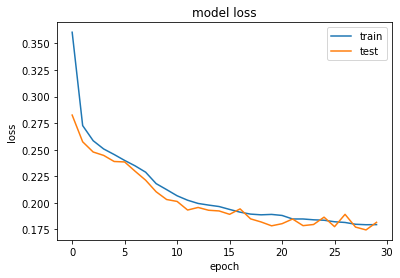

In [46]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

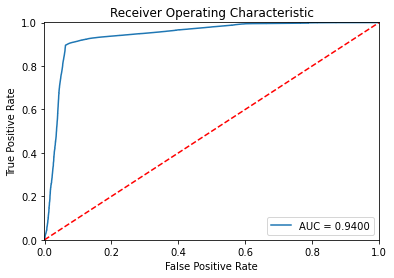

In [47]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error,pos_label=1)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Text(0.5, 1.0, 'Recall vs Precision')

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

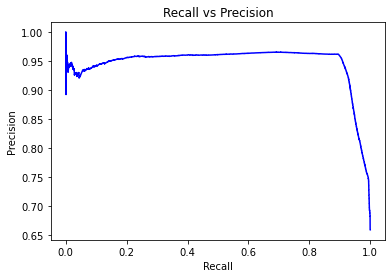

In [48]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error,pos_label=1)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()